In [1]:
import arviz as az
import os
import pandas as pd
import toml
from IPython.display import Image
from matplotlib import pyplot as plt
plt.style.use('sparse.mplstyle')

# Introduction to Maud

I was bored the other day so I put an organism in a bioreactor and ran some multi-omics analysis.

Using metabolomics I measured the steady state cytosolic concentrations of three metabolites - M2, M3 and M4. I ran some proteomics to find out the concentration of six enzymes - r1, r2, r3, r4 and r5 - and did some fluxomics to find out the flux through the r1 reaction. I ran this experiment twice, varying the conditions a little.

Unfortunately my measurements weren't perfectly accurate, but I had a fairly good idea about how accurate they were and recorded this information alongside the observations. Here's what my results looked like:

In [2]:
data = toml.load('toy.toml')

def get_measurements(experiment, measurement_type):
    out = pd.DataFrame(experiment[measurement_type])
    out = out.rename(columns={'uncertainty': 'measurement_error',
                              'value': 'measurement',
                              'target_id': measurement_type.replace('_measurements', '')})
    out['experiment_id'] = experiment['id']
    return out

metabolite_measurements, flux_measurements, enzyme_measurements = (
    pd.concat(map(lambda e: get_measurements(e, measurement_type=t), data['experiments']))
    for t in ['metabolite_measurements', 'reaction_measurements', 'enzyme_measurements']
)

print("Metabolite measurements:")
display(metabolite_measurements)

print("Flux measurements:")
display(flux_measurements)

print("Enzyme measurements:")
display(enzyme_measurements)

Metabolite measurements:


,metabolite,measurement,measurement_error,experiment_id
0,M1_e,3.30,0.10,condition_1
1,M2_e,1.00,0.10,condition_1
2,M4_e,1.34,0.10,condition_1
3,M2_c,1.56,0.05,condition_1
4,M3_c,1.07,0.05,condition_1
5,M4_c,3.41,0.05,condition_1
0,M1_e,2.40,0.10,condition_2
1,M2_e,1.10,0.10,condition_2
2,M4_e,0.54,0.10,condition_2
3,M2_c,1.23,0.05,condition_2


Flux measurements:


,reaction,measurement,measurement_error,experiment_id
0,r1,0.14,0.05,condition_1
0,r1,0.13,0.05,condition_2


Enzyme measurements:


,enzyme,measurement,measurement_error,experiment_id
0,r1,1.0,0.05,condition_1
1,r2,1.5,0.05,condition_1
2,r3,2.0,0.05,condition_1
3,r4,1.5,0.05,condition_1
4,r5,1.5,0.05,condition_1
5,r6,1.0,0.05,condition_1
0,r1,1.0,0.05,condition_2
1,r2,1.0,0.05,condition_2
2,r3,1.0,0.05,condition_2
3,r4,1.0,0.05,condition_2


Ok, I thought, what if I changed the conditions again? What measurements would I get?

At this point my patience was wearing thin and I couldn't be bothered to do another experiment and multi-omics analysis. It seemed like much more fun to instead predict what would happen using computational modelling.

From memory I jotted down a kinetic model describing my organism's rather simple metabolism:

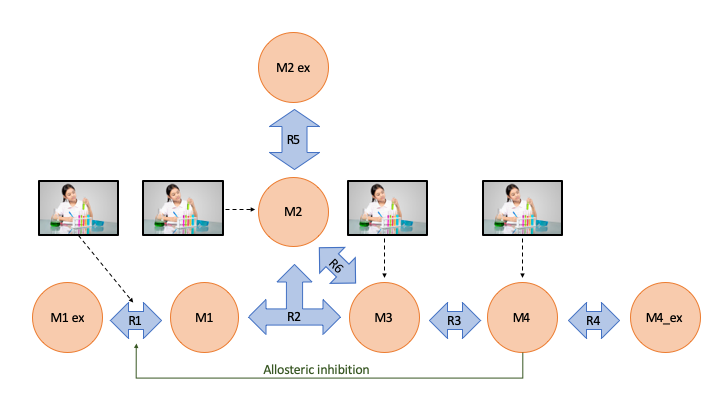

In [3]:
Image("kinetic_model.png")

The arrows connected to pictures indicate which metabolites and reactions I measured, while the green arrow labelled 'Allosteric inhibition' represents my knowledge that the metabolite M4 inhibits the reaction r1.

I happen to know that all of the reactions in this network are well described by the modular rate law, and had a quick look on [BRENDA](https://www.brenda-enzymes.org/oldstart.php) and [Equilibrator](http://equilibrator.weizmann.ac.il/) to find some handy prior distributions for the parameters that feature in these laws.

I put all my information into the toml file `data.toml`, installed Maud, ran the following command on my computer and took a long and well-deserved coffee break while it executed:

In [4]:
!maud sample toy.toml --n_warmup 100 --n_samples 100

INFO:cmdstanpy:compiling stan program, exe file: /Users/tedgro/Code/introduction_to_maud/inference_model_toy
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/tedgro/.pyenv/versions/3.7.2/lib/python3.7/site-packages/maud/stan_code', '/Users/tedgro/Code/introduction_to_maud']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/tedgro/Code/introduction_to_maud/inference_model_toy
Chain 2 - warmup:   0%|                                   | 0/1 [00:00<?, ?it/s]

Chain 1 - warmup:   0%|                                   | 0/1 [00:00<?, ?it/s]


Chain 2 - warmup:   0%|                                   | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                   | 0/1 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|                                   | 0/1 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|                                 | 0/200 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|                                 | 0/200 [00:00<?, ?it/s]


Chain 4

From the terminal output I saw that the samples had no divergent transitions, and the Split R-hat, effective sample size and E-BGMI diagnostics were all ok. There was a good chance that Maud had successfully explored my target probability distribution. 

Now I just needed to analyse the output. I loaded the results from the output csvs with a nice analysis package called [arviz](https://arviz-devs.github.io/arviz/).

In [5]:
csvs = [f for f in os.listdir('.') if f.endswith('.csv')]

infd = az.from_cmdstan(csvs)

First I made a graphical posterior predictive check, testing whether my fitted model was able to simulate data that more-or-less agreed with my measurements:

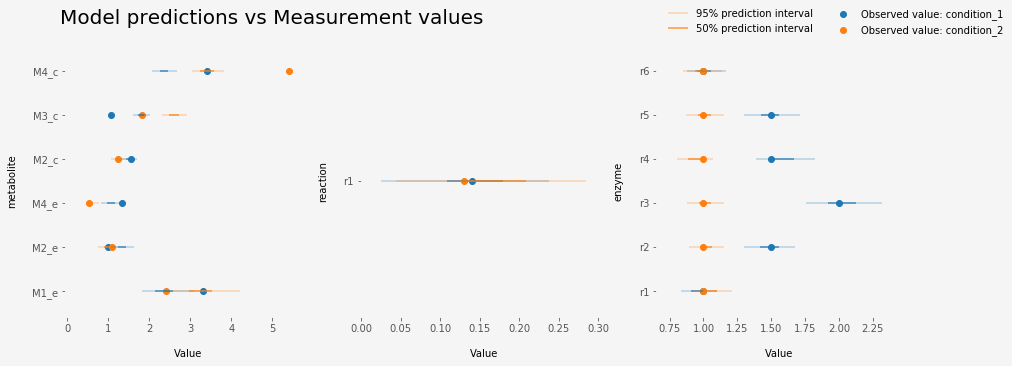

In [6]:
for q in [0.025, 0.25, 0.5, 0.75, 0.975]:
    colname = 'q_' + str(q)
    metabolite_measurements[colname] = infd.posterior['yconc_sim'].quantile(q, dim=['chain', 'draw'])
    flux_measurements[colname] = infd.posterior['yflux_sim'].quantile(q, dim=['chain', 'draw'])
    enzyme_measurements[colname] =  infd.posterior['yenz_sim'].quantile(q, dim=['chain', 'draw'])

dfs = [metabolite_measurements, flux_measurements, enzyme_measurements]
target_cols = ['metabolite', 'reaction', 'enzyme']
f, axes = plt.subplots(1, 3, figsize=[15, 5])
leg_handles = {}
for ax, df, target_col in zip(axes, dfs, target_cols):
    for eid in df['experiment_id'].unique():
        d = df.loc[lambda df: df['experiment_id'] == eid]
        sctr = ax.scatter(d['measurement'], d[target_col], label=eid)        
        hl1 = ax.hlines(d[target_col], d['q_0.025'], d['q_0.975'], color=sctr.get_facecolors()[0], alpha=0.3)
        hl2 = ax.hlines(d[target_col], d['q_0.25'], d['q_0.75'], color=sctr.get_facecolors()[0], alpha=0.8)
        leg_handles['95% prediction interval'] = hl1
        leg_handles['50% prediction interval'] = hl2
        leg_handles['Observed value: ' + eid] = sctr
        ax.set(xlabel="Value", ylabel=target_col)
leg = f.legend(leg_handles.values(), leg_handles.keys(), frameon=False, ncol=2, loc='upper right')
st = f.suptitle("Model predictions vs Measurement values", horizontalalignment="left", x=0.12, fontsize=20)

Uh oh! Several metabolite concentration measurements were well outside the model's predictive intervals. 

Something must have gone wrong, either in my measurements or the prior distributions I fed in. Time to go back to the drawing board...